In [1]:
import pandas as pd
import numpy as np
import pickle
import torch
import networkx as nx
from neo4j import GraphDatabase
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

In [2]:
def load_network(file_path):
    net = pd.read_table(filepath_or_buffer=file_path, header=None,
                        index_col=None, names=['source', 'target'], sep='\t')
    nodes = pd.concat([net['source'], net['target']], ignore_index=True)
    nodes = pd.DataFrame(nodes, columns=['nodes']).drop_duplicates()
    nodes.reset_index(drop=True, inplace=True)
    return net, nodes

In [3]:
def build_customized_feature_matrix(feat_files, network_file):

    dataframes = [pd.read_csv(file, sep='\t', index_col=0) for file in feat_files]
    
    full_data = pd.concat(dataframes, axis=1)
    
    dataset_names = [col for col in full_data.columns if "GE:" in col]
    return full_data[dataset_names]

In [4]:
def create_edge_index(network_file, net_features):
    
    net, _ = load_network(network_file)
    node_df = pd.DataFrame({'name': net_features.index.values.tolist(),
                            'id': np.arange(net_features.shape[0])})
    
    net = pd.merge(net, node_df, how='left', left_on='source', right_on='name')
    net = pd.merge(net, node_df, how='left', left_on='target', right_on='name')

    edge_index = net[['id_x', 'id_y']].dropna().astype(int).values
    edge_index = np.vstack([edge_index, edge_index[:, ::-1]])
    
    return torch.LongTensor(edge_index.T)

In [5]:
def generate_5CV_set(drivers,nondrivers,randseed):
    X, y = drivers + nondrivers, np.hstack(([1]*len(drivers), [0]*len(nondrivers)))
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=randseed)
    X_5CV = {}
    cv_idx=1
    for train, test in skf.split(X, y):
        train_set=[]
        train_label=[]
        test_set=[]
        test_label=[]
        for i in train:
            train_set.append(X[i])
            train_label.append(y[i])
        for i in test:
            test_set.append(X[i])
            test_label.append(y[i])
        X_5CV['train_%d' % cv_idx] = train_set
        X_5CV['test_%d' % cv_idx] = test_set
        X_5CV['train_label_%d' % cv_idx] = train_label
        X_5CV['test_label_%d' % cv_idx] = test_label
        cv_idx = cv_idx + 1
    return X_5CV

In [6]:
feat_file_lst = ['GE_expression_matrix.tsv']

In [7]:
network_file = 'PathNet.txt'

In [8]:
feat_name_lst = ['exp']

In [9]:
net_features = build_customized_feature_matrix(feat_file_lst, network_file)

In [10]:
print(net_features)

            GE: KIRC  GE: BRCA  GE: READ  GE: PRAD  GE: STAD  GE: HNSC  \
Unnamed: 0                                                               
STIM1       0.021826  0.078583  0.081009  0.024927  0.058403  0.054881   
TRPC1       0.035037  0.175396  0.127587  0.160771  0.025139  0.017627   
NOS1        0.317315  0.366842  0.362653  0.327616  0.386143  0.240406   
ATP2B4      0.058874  0.121747  0.254115  0.198962  0.000587  0.046899   
ABCC9       0.006580  0.252722  0.109012  0.148716  0.036229  0.008346   
...              ...       ...       ...       ...       ...       ...   
GPR153      0.021059  0.048254  0.010328  0.087304  0.032409  0.133440   
HDC         0.122908  0.159479  0.135696  0.030383  0.155934  0.015314   
CSMD1       0.131125  0.319950  0.000000  0.214714  0.129068  0.184721   
BHLHE22     0.001159  0.139090  0.046438  0.125946  0.038114  0.048209   
PROKR1      0.109166  0.559162  0.262671  0.278055  0.000000  0.000000   

            GE: LUAD  GE: THCA  GE: B

In [11]:
dataset=dict()
dataset['feature'] = torch.FloatTensor(np.array(net_features))
dataset['node_name'] = net_features.index.values.tolist()

In [12]:
# Create edge_index by edges in network file
edge_index = create_edge_index(network_file,net_features)
dataset['edge_index'] = torch.LongTensor(np.array(edge_index).transpose())
dataset['feature_name'] = net_features.columns.values.tolist()

In [13]:
d_lst = pd.read_table("796_drivers.txt", sep='\t', header=None, names=['driver'])['driver'].tolist()
nd_lst = pd.read_table("2187_nondrivers.txt", sep='\t', header=None, names=['nondriver'])['nondriver'].tolist()

In [14]:
labels = [1 if g in d_lst else 0 for g in dataset['node_name']]
mask = [True if g in d_lst or g in nd_lst else False for g in dataset['node_name']]

In [15]:
dataset['label'] = torch.FloatTensor(labels)
dataset['mask'] = np.array(mask)

# Generate 10 rounds of 5-fold CV splits
d_in_net = [g for g in dataset['node_name'] if g in d_lst]
nd_in_net = [g for g in dataset['node_name'] if g in nd_lst]

k_sets_net = dict()
for k in range(10):
    randseed = (k+1) % 100 + (k+1) * 5
    cv_splits = generate_5CV_set(d_in_net, nd_in_net, randseed)
    k_sets_net[k] = [
        (np.array([g in cv_splits[f'train_{i}'] for g in dataset['node_name']]),
         np.array([g in cv_splits[f'test_{i}'] for g in dataset['node_name']]))
        for i in range(1, 6)
    ]

dataset['split_set'] = k_sets_net

In [16]:
URI = "bolt://localhost:7687"  # Update if needed
AUTH = ("neo4j", "your_password")  # Replace with your actual password

driver = GraphDatabase.driver(URI, auth=AUTH)

In [17]:
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return list(result)  # Convert result to a list before returning

In [18]:
def save_graph_to_neo4j(dataset):
    with driver.session() as session:
        # Create Genes
        for i, gene in enumerate(dataset['node_name']):
            label = int(dataset['label'][i].item())  # Convert tensor to int
            session.run(
                "CREATE (:Gene {name: $name, label: $label})",
                {"name": gene, "label": label}
            )
            print(f"Creating: {i}/{len(dataset['node_name'])}", end = '\r')

        # Create Interactions (Limit to First 100)
        edge_index = dataset['edge_index']

        # Ensure edge_index has the correct shape
        if edge_index.shape[1] != 2:
            raise ValueError("edge_index should have shape (num_edges, 2), but got: " + str(edge_index.shape))

        # Consider only first 100 edges
        limited_edges = edge_index[:100].tolist()  # Slice first 100 edges

        for i, (source_idx, target_idx) in enumerate(limited_edges):
            source_gene = dataset['node_name'][source_idx]
            target_gene = dataset['node_name'][target_idx]

            session.run(
                "MATCH (a:Gene {name: $source}), (b:Gene {name: $target}) "
                "CREATE (a)-[:INTERACTS_WITH]->(b)",
                {"source": source_gene, "target": target_gene}
            )
            print(f'Edges: {i}/{len(limited_edges)}', end = '\r')
            
save_graph_to_neo4j(dataset)
print("Graph saved to Neo4j.")

Graph saved to Neo4j.


Create a new Gene

In [19]:
run_query("CREATE (:Gene {name: 'NewGene', label: 1})")

[]

Read all Genes

In [20]:
result = run_query("MATCH (g:Gene) RETURN g.name LIMIT 10")
records = list(result)  # Convert result iterator to a list

print([record["g.name"] for record in records])  # Iterate over stored records

['STIM1', 'TRPC1', 'NOS1', 'ATP2B4', 'ABCC9', 'KCNJ11', 'HADHA', 'HADHB', 'GTF2E2', 'GTF2E1']


Update a Gene's Label

In [21]:
run_query("MATCH (g:Gene {name: 'NewGene'}) SET g.label = 0")

[]

Delete a Gene

In [22]:
run_query("MATCH (g:Gene {name: 'NewGene'}) DELETE g")

[]

Count Total Genes

In [24]:
result = run_query("MATCH (g:Gene) RETURN count(g) AS GeneCount")

if result:  # Check if result is not empty
    print(result[0]["GeneCount"])  # Access the first record
else:
    print("No records found.")

88606


Find genes interacting with a specific gene

In [25]:
result = run_query("MATCH (g:Gene {name: 'TP53'})-[:INTERACTS_WITH]-(other) RETURN other.name")
print([record["other.name"] for record in result])

['TSC2', 'SCO2', 'IGFBP3', 'PMAIP1', 'TP53AIP1', 'ZNF420', 'STEAP3', 'BNIP3L', 'AIFM2', 'APAF1', 'PIDD1', 'ZNF385A', 'TPX2', 'TP73', 'TRAF6', 'GTSE1', 'AKT1', 'SLC7A11', 'SMARCA4', 'SERPINE1', 'WRN', 'UBE2D1', 'YY1', 'TP63', 'AKT2', 'USP7', 'TRIM28', 'UBB', 'SIVA1', 'UBC', 'CCNG2', 'SERPINB5', 'AKT3', 'UBA52', 'TP53RK', 'RPRM', 'UBE3A', 'SAT1', 'SAT2', 'CDKN2C', 'CD82', 'ZMAT3', 'TTC5', 'EI24', 'PERP', 'TADA2B', 'ADGRB1', 'SHISA5', 'THBS1', 'ZNF274', 'SESN3', 'TSC2', 'SCO2', 'IGFBP3', 'PMAIP1', 'TP53AIP1', 'ZNF420', 'STEAP3', 'BNIP3L', 'AIFM2', 'APAF1', 'PIDD1', 'ZNF385A', 'TPX2', 'TP73', 'TRAF6', 'GTSE1', 'AKT1', 'SLC7A11', 'SMARCA4', 'SERPINE1', 'WRN', 'UBE2D1', 'YY1', 'TP63', 'AKT2', 'USP7', 'TRIM28', 'UBB', 'SIVA1', 'UBC', 'CCNG2', 'SERPINB5', 'AKT3', 'UBA52', 'TP53RK', 'RPRM', 'UBE3A', 'SAT1', 'SAT2', 'CDKN2C', 'CD82', 'ZMAT3', 'TTC5', 'EI24', 'PERP', 'TADA2B', 'ADGRB1', 'SHISA5', 'THBS1', 'ZNF274', 'SESN3', 'TSC2', 'SCO2', 'IGFBP3', 'PMAIP1', 'TP53AIP1', 'ZNF420', 'STEAP3', 'BNIP

Find the most connected driver genes

In [27]:
top_interactions = [(r["g.name"], r["interactions"]) for r in result]
print(top_interactions)

[('AKT1', 4806), ('RAC1', 3618), ('PRKACA', 3456), ('MAPK1', 3411), ('AKT2', 3204)]


Find the shortest path between two genes

In [29]:
result = run_query("""
    MATCH path = shortestPath((g1:Gene {name: 'TP53'})-[:INTERACTS_WITH*]-(g2:Gene {name: 'EGFR'})) 
    RETURN path
""")

if result:
    print(result[0]["path"]) 
else:
    print("No path found between TP53 and EGFR.")

<Path start=<Node element_id='4:a5fa02e7-5b2e-41c9-b595-062bfc606686:89' labels=frozenset({'Gene'}) properties={'name': 'TP53', 'label': 1}> end=<Node element_id='4:a5fa02e7-5b2e-41c9-b595-062bfc606686:18' labels=frozenset({'Gene'}) properties={'name': 'EGFR', 'label': 1}> size=2>


Find the most connected gene

In [32]:
result = run_query("""
    MATCH (g:Gene)-[r:INTERACTS_WITH]-() 
    RETURN g.name, count(r) AS connections 
    ORDER BY connections DESC LIMIT 1
""")
if result:
    print(result[0])  # Access the first result in the list

result = run_query("""
    MATCH (g:Gene)-[r:INTERACTS_WITH]-() 
    RETURN g.name, count(r) AS connections 
    ORDER BY connections DESC LIMIT 5
""")
for record in result:
    print(record["g.name"], record["connections"])

<Record g.name='AAAS' connections=7745>
AAAS 7745
RPS27A 5283
UBA52 5247
AKT1 4806
UBC 4473


Visualization 

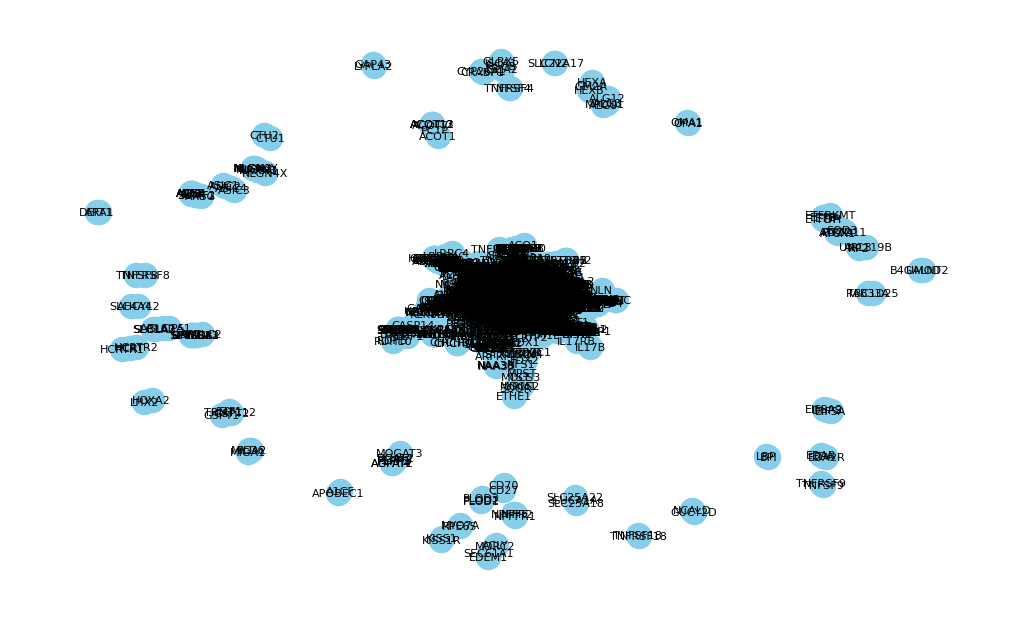

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph():
    result = run_query("MATCH (g:Gene)-[:INTERACTS_WITH]-(other) RETURN g.name, other.name")
    edges = [(record["g.name"], record["other.name"]) for record in result]
    
    G = nx.Graph()
    G.add_edges_from(edges)

    plt.figure(figsize=(10, 6))
    nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', font_size=8)
    plt.show()

visualize_graph()

Calculate Clustering Coefficient

In [36]:
G = nx.erdos_renyi_graph(10, 0.4)  # Example: Random graph with 10 nodes and 40% chance of edge creation

# Calculate the clustering coefficient for each node in the graph
clustering_coeffs = nx.clustering(G)

# Print the clustering coefficient for each node
print("Clustering Coefficients for each node:")
for node, coeff in clustering_coeffs.items():
    print(f"Node {node}: {coeff}")

# Calculate the average clustering coefficient of the entire graph
avg_clustering_coeff = nx.average_clustering(G)
print(f"\nAverage Clustering Coefficient: {avg_clustering_coeff}")


Clustering Coefficients for each node:
Node 0: 0.4
Node 1: 0.5
Node 2: 0
Node 3: 0.3333333333333333
Node 4: 1.0
Node 5: 1.0
Node 6: 0.6666666666666666
Node 7: 1.0
Node 8: 0.6
Node 9: 0

Average Clustering Coefficient: 0.55
